In [6]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

import flaml
from flaml import AutoML

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

if os.path.exists('/media/ssd_2tb_evo/DL_based_wind_profile_estimation'):
    root_dir = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation'
elif os.path.exists('/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'):
    root_dir = '/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'
else:
    root_dir = '/Users/harishbaki/Ongoing_Research/DL_based_wind_profile_estimation'

sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5_to_CERRA.yaml' #sys.argv[1]
train_years = int(17) #int(sys.argv[2])
Ens = 0 #int(sys.argv[3]) #ensemble number

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    configure = yaml.safe_load(yaml_file)
input_file = configure['input_file']
input_times_freq = configure['input_times_freq']
Coeff_file = configure['Coeff_file']
profiles_file = None if configure['profiles_file'] == '' else configure['profiles_file']
input_variables = configure['input_variables']
train_locations = configure['train_locations']
test_dates_range = configure['test_dates_range']
test_locations = configure['test_locations']
nEns = configure['nEns']
tabnet_param_file = configure['tabnet_param_file']
target_variables = configure['target_variables']
experiment = configure['experiment']

In [7]:
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY",
    "u10","v10","u100","v100","u_950","v_950","u_975","v_975",
    "u10_mean","u10_std","u10_skew","u10_kurt",
    "v10_mean","v10_std","v10_skew","v10_kurt",
    "u100_mean","u100_std","u100_skew","u100_kurt",
    "v100_mean","v100_std","v100_skew","v100_kurt",
    "u_950_mean","u_950_std","u_950_skew","u_950_kurt",
    "v_950_mean","v_950_std","v_950_skew","v_950_kurt",
    "u_975_mean","u_975_std","u_975_skew","u_975_kurt",
    "v_975_mean","v_975_std","v_975_skew","v_975_kurt",
]

In [9]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T03:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-10T12:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T03:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T12:00:00','2018-01-05T04:00:00'],
                }
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

In [10]:
#for run,year in enumerate(np.arange(2000,2017+1-train_years)):
train_dates_range = ['2000-01-01T12','2016-12-31']
print(train_dates_range)

# === training and validation data parameters ===#
X_train,Y_train, X_valid,Y_valid = data_processing(input_file,Coeff_file,input_times_freq,
                                                    input_variables,target_variables,train_dates_range,train_locations,val_arg=True,
                                                    profiles_file=profiles_file,threshold=2)
print('training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape,'validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)

['2000-01-01T12', '2016-12-31']
training inputs shape: (110071, 72) training targets shape: (110071, 5) validation inputs shape: (27073, 72) validation targets shape: (27073, 5)


In [11]:
import pandas as pd

# Define the start and end dates
start_date = pd.Timestamp('2000-01-01T12')
end_date = pd.Timestamp('2016-12-31')

# Calculate the number of hours between the dates
hours_between = (end_date - start_date).total_seconds() / 3600

print("Number of hours between 2000 Jan 1 and 2016 Dec 31:", hours_between)


Number of hours between 2000 Jan 1 and 2016 Dec 31: 149004.0


### Simple AutoML xgboost regresison or lgbm
- Experimented with xgboost, but the performance is quite unsatisfactory

In [26]:
automl_settings = {
    "time_budget": 3600,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['xgboost'],
    "early_stop": True,
    "model_history": True, #A boolean of whether to keep the best model per estimator
    "retrain_full": True, #whether to retrain the selected model on the full training data
    "custom_hp": {
        "xgboost": {
            "tree_method": {
                "domain": "gpu_hist",       # Use GPU for tree construction
                "type": "fixed"
            },
            "predictor": {
                "domain": "gpu_predictor",  # Use GPU for prediction
                "type": "fixed"
            }
        }
    }
}

In [13]:
trained_models = {}
# === Target variables ===#
target_variables = [0,1,2,3,4] #represent coefficients from 0 to 4
for i,target_variable in enumerate(target_variables):
    # === initialize automl regressor ===#
    automl = AutoML()
    # === Train AUTOML regressor ===#
    X_tr,y_tr,X_val,y_val = np.hstack([X_train,Y_train[:,0:i]]), Y_train[:,i:i+1], np.hstack([X_valid,Y_valid[:,0:i]]), Y_valid[:,i:i+1]
    print(X_tr.shape,y_tr.shape,X_val.shape,y_val.shape)

    automl.fit(X_train=X_tr, y_train = y_tr,X_val=X_val, y_val=y_val, **automl_settings)

    # === save the model ===#
    trained_models[f'Coefficient_{target_variable}'] = automl

(110071, 72) (110071, 1) (27073, 72) (27073, 1)
[flaml.automl.logger: 04-18 19:27:18] {1728} INFO - task = regression


[flaml.automl.logger: 04-18 19:27:18] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 04-18 19:27:18] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-18 19:27:18] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 04-18 19:27:18] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 04-18 19:27:18] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 04-18 19:27:18] {2393} INFO - Estimated sufficient time budget=27405s. Estimated necessary time budget=27s.
[flaml.automl.logger: 04-18 19:27:18] {2442} INFO -  at 0.3s,	estimator xgboost's best error=3.5681,	best estimator xgboost's best error=3.5681
[flaml.automl.logger: 04-18 19:27:18] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 04-18 19:27:18] {2442} INFO -  at 0.3s,	estimator xgboost's best error=3.5681,	best estimator xgboost's best error=3.5681
[flaml.automl.logger: 04-18 19:27:18] {2258} INFO - iteration 2, 

In [14]:
# === testing data parameters ===#
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (9216, 72) testing targets shape: (9216, 5)


(9216, 72) (9216, 1)
(9216, 1)
(9216, 73) (9216, 1)
(9216, 2)
(9216, 74) (9216, 1)
(9216, 3)
(9216, 75) (9216, 1)
(9216, 4)
(9216, 76) (9216, 1)
(9216, 5)


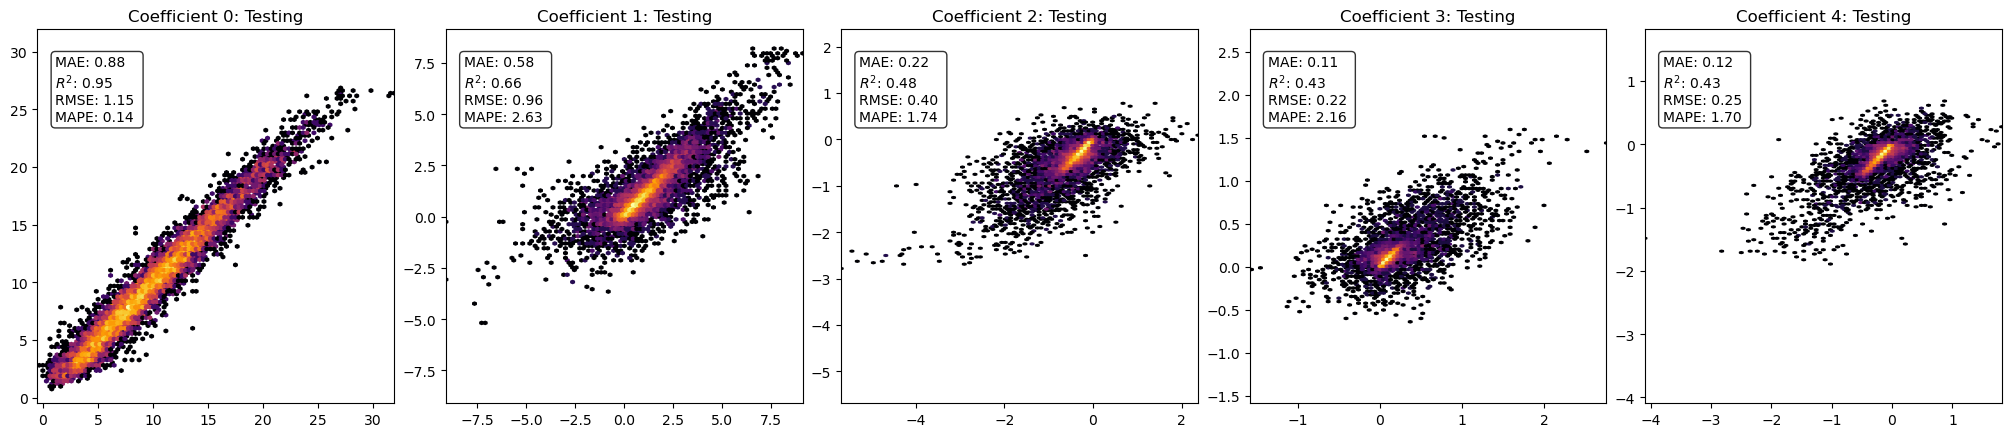

In [15]:
fig = plt.figure(figsize=(20, 8), constrained_layout=True)
gs = fig.add_gridspec(2,5)

Y_pred = []
for i,target_variable in enumerate(target_variables):
    X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
    y_te = Y_test[:,i:i+1]
    print(X_te.shape,y_te.shape)
    y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
    y_pred = y_pred.reshape(-1,1)
    Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_pred.shape)
    hexbin_plotter(fig,gs[0,i],y_te,y_pred,f'Coefficient {target_variable}: Testing',text_arg=True)

#plt.savefig(f'Figures/single_output_lgbm_CERRA_targets_coefficients_hexbin_plot.png',dpi=300)

In [38]:
Z = [10., 15., 30., 50., 75., 100., 150., 200., 250., 300]
ref_H = np.unique(np.concatenate((np.array([0]),Z)))
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,X_test,Y_test,ERA5_ws=None,Obs=None,date=None,title=None,xlabel=None,ylabel=None,train_years=None,run=None,experiment=experiment):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[0,0:2] if ERA5_ws is None else ERA5_ws
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate observed profile
    M_true = WindProfile(Z, Y_test[0,:],ref_H = ref_H)
    print(M_true)
    axs.plot(M_true, Z, '-k', linewidth=2, markerfacecolor='r', label='CERRA')

    Mp = WindProfile(Z, Y_pred[0,:],ref_H = ref_H)
    print(Mp)

    # Plot Mp
    axs.plot(Mp, Z, linestyle='-', linewidth=2, label='XGBoost', markerfacecolor='b')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

### Best profiles

High shear 2017-10-17T03:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[15.44729126  2.83240244 -0.44024953  0.17322118 -0.25369138]] [[17.631622    3.6434503  -0.4247728   0.1379081  -0.33050022]]
[11.74772673 11.95073938 12.4986754  13.10243631 13.68881785 14.13000537
 14.7307122  15.15957609 15.58712298 16.09938542]
[13.09499094 13.33081589 13.96526067 14.66063459 15.33252836 15.83757676
 16.53869976 17.07833137 17.66072435 18.3800565 ]
Low shear/well mixed 2017-05-10T12:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[ 8.22929753  0.46051726 -0.21722734  0.07255129 -0.11483661]] [[ 6.0941315   0.36350638 -0.1410039   0.0459913  -0.07760841]]
[7.36416503 7.43969644 7.63879224 7.8471754  8.03188349 8.15119615
 8.26270855 8.29595501 8.32693092 8.39338471]
[5.46602148 5.51712172 5.65207266 5.79395622 5.92088843 6.00442515
 6.08768292 6.12031619 6.15306373 6.21081635]
LLJ 2018-04-10T03:00:00
(1, 72) (1, 1)
(1, 73) (1,

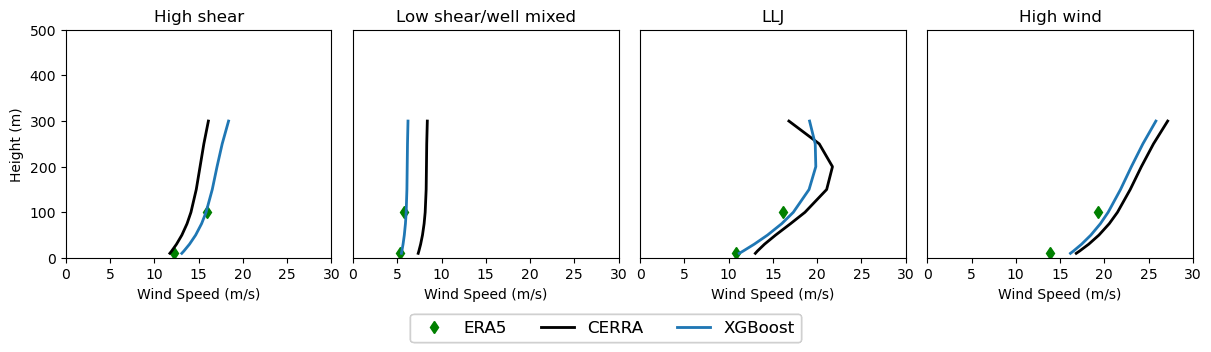

In [39]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)

for k,profile in enumerate(profile_dates):
    print(profile, profile_dates[profile][0])

    X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    Y_pred = []
    for i,target_variable in enumerate(target_variables):
        X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
        y_te = Y_test[:,i:i+1]
        print(X_te.shape,y_te.shape)
        y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
        y_pred = y_pred.reshape(-1,1)
        Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_test,Y_pred)

    title = profile
    xlabel = f'Wind Speed (m/s)'
    ylabel = f'Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[0,k],X_test,Y_test,title=title,xlabel=xlabel,ylabel=ylabel)

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

### Worst profiles

High shear 2017-10-17T03:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[12.00334472  3.45937621 -0.96071262  0.42751979 -0.36379203]] [[13.348647    2.627335   -1.0966117   0.5709695  -0.27424935]]
[ 6.79194407  7.12939772  8.04046882  9.04283791 10.00864838 10.7196461
 11.61618493 12.13469086 12.55623731 13.04073469]
[ 8.77948144  9.1088002  10.00226851 10.99303707 11.95464992 12.66300351
 13.52545713 13.93435859 14.15232827 14.35064622]
Low shear/well mixed 2017-05-10T12:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[ 8.21882072 -0.38652453 -0.31040635  0.09187151 -0.12291103]] [[ 8.469307   -0.05056548 -0.2554248   0.0779452  -0.15393323]]
[8.08015636 8.15188696 8.33604434 8.51686544 8.65621903 8.71972383
 8.69456744 8.56657194 8.41997676 8.29808512]
[8.03256921 8.11384613 8.32229245 8.52700741 8.68627782 8.76292257
 8.7589556  8.66430473 8.57689989 8.54340262]
LLJ 2018-04-10T03:00:00
(1, 72) (1, 1)
(1, 73) (1, 

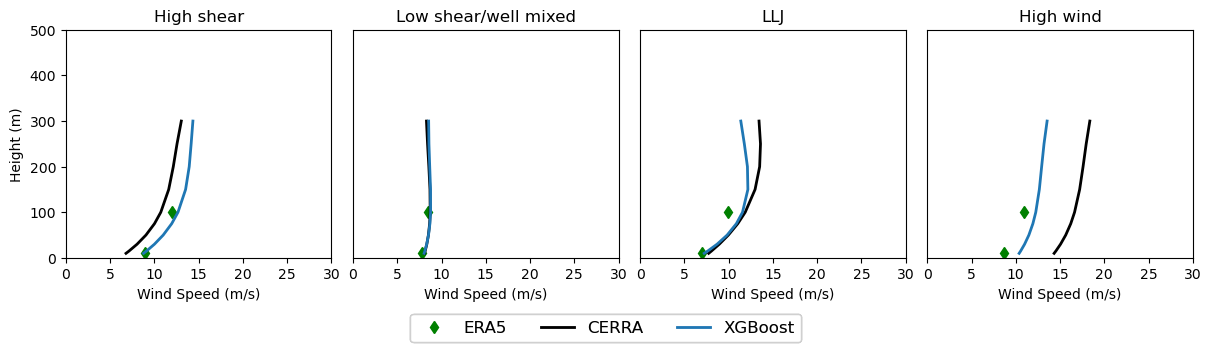

In [40]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)

for k,profile in enumerate(profile_dates):
    print(profile, profile_dates[profile][0])

    X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    Y_pred = []
    for i,target_variable in enumerate(target_variables):
        X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
        y_te = Y_test[:,i:i+1]
        print(X_te.shape,y_te.shape)
        y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
        y_pred = y_pred.reshape(-1,1)
        Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_test,Y_pred)

    title = profile
    xlabel = f'Wind Speed (m/s)'
    ylabel = f'Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[0,k],X_test,Y_test,title=title,xlabel=xlabel,ylabel=ylabel)

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)